# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# # 한글 폰트가 깨지면 실행하세요! 
# # 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
# import matplotlib.font_manager as fm
# fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# # 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
# fontlist[:]

# from matplotlib import font_manager, rc
# #font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
# font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
# path = "./Dataset/"

# # original data : data 
# data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
# data


data =  pd.read_csv("../train.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data_label =  pd.read_csv("../train_label.csv")


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터 
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

**basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date

**activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [4]:
# data + data_label 
# data['DIAG_NM'] = data_label

label_dict =  dict([(i,a) for i,a in zip(data_label['SAMPLE_EMAIL'], data_label['DIAG_NM'])])

# DIAG_NM
data['DIAG_NM'] = data['EMAIL'].map(label_dict)
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 51 columns**


**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data


- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [6]:
# column의 수가 많기 때문에 효율적으로 관리하기 위해서 
# column의 이름들을 묶어서 진행합시다
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min',
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation']
convert_cols = data.iloc[:, 60:65].columns

In [7]:
convert_cols

Index(['CONVERT(activity_class_5min USING utf8)',
       'CONVERT(activity_met_1min USING utf8)',
       'CONVERT(sleep_hr_5min USING utf8)',
       'CONVERT(sleep_hypnogram_5min USING utf8)',
       'CONVERT(sleep_rmssd_5min USING utf8)'],
      dtype='object')

In [8]:
# data -> processed_data 
# Drop Features 
processed_data = data.drop(drop_cols, axis=1).copy()
processed_data = processed_data.drop(convert_cols, axis=1).copy()
processed_data

,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,2020-11-27,1.71875,730,2944,14346,0,417,0,545,47,...,62,100,41,50,27,97,66,62,-0.12,CN
1,2020-11-28,1.40625,342,2449,6352,0,473,0,392,8,...,54,100,49,43,46,91,35,44,-0.32,CN
2,2020-11-29,1.46875,401,2544,7297,0,586,0,362,24,...,61,100,56,47,34,89,41,62,0.07,CN
3,2020-11-30,0.34375,27,1850,491,0,176,0,34,1,...,55,100,35,40,44,86,29,56,-0.41,CN
4,2020-12-01,1.46875,333,2518,5861,0,646,0,377,6,...,56,100,64,55,39,14,54,59,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2020-12-22,1.34375,227,2316,3863,3,735,2,155,17,...,76,100,53,46,74,97,84,82,-0.16,CN
9323,2020-12-24,1.34375,249,2351,4411,1,780,4,167,22,...,77,100,34,57,76,81,95,86,-0.09,CN
9324,2020-12-26,1.53125,570,2682,11057,1,518,1,332,61,...,65,100,1,56,69,86,89,64,0.41,CN
9325,2020-12-27,1.34375,295,2331,5135,4,578,0,173,30,...,81,100,9,59,86,89,98,97,0.27,CN


In [9]:
processed_data = processed_data.drop('summary_date', axis=1).copy()
processed_data

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,730,2944,14346,0,417,0,545,47,0,...,62,100,41,50,27,97,66,62,-0.12,CN
1,1.40625,342,2449,6352,0,473,0,392,8,0,...,54,100,49,43,46,91,35,44,-0.32,CN
2,1.46875,401,2544,7297,0,586,0,362,24,0,...,61,100,56,47,34,89,41,62,0.07,CN
3,0.34375,27,1850,491,0,176,0,34,1,0,...,55,100,35,40,44,86,29,56,-0.41,CN
4,1.46875,333,2518,5861,0,646,0,377,6,0,...,56,100,64,55,39,14,54,59,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.34375,227,2316,3863,3,735,2,155,17,21,...,76,100,53,46,74,97,84,82,-0.16,CN
9323,1.34375,249,2351,4411,1,780,4,167,22,7,...,77,100,34,57,76,81,95,86,-0.09,CN
9324,1.53125,570,2682,11057,1,518,1,332,61,7,...,65,100,1,56,69,86,89,64,0.41,CN
9325,1.34375,295,2331,5135,4,578,0,173,30,28,...,81,100,9,59,86,89,98,97,0.27,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [10]:
processed_data.columns

Index(['activity_average_met', 'activity_cal_active', 'activity_cal_total',
       'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sleep_score', 'sle

In [46]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# processed_data -> input_data 
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [47]:
# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


# 5. Data Scaling 

scale data to get high accuracy
근데 과연 아래 알고리즘에도 영향이 있을까?

- RobustScaler  
- log transform

## Transform

In [41]:
input_data_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   activity_average_met               9327 non-null   float64
 1   activity_cal_active                9327 non-null   int64  
 2   activity_cal_total                 9327 non-null   int64  
 3   activity_daily_movement            9327 non-null   int64  
 4   activity_high                      9327 non-null   int64  
 5   activity_inactive                  9327 non-null   int64  
 6   activity_inactivity_alerts         9327 non-null   int64  
 7   activity_low                       9327 non-null   int64  
 8   activity_medium                    9327 non-null   int64  
 9   activity_met_min_high              9327 non-null   int64  
 10  activity_met_min_inactive          9327 non-null   int64  
 11  activity_met_min_low               9327 non-null   int64

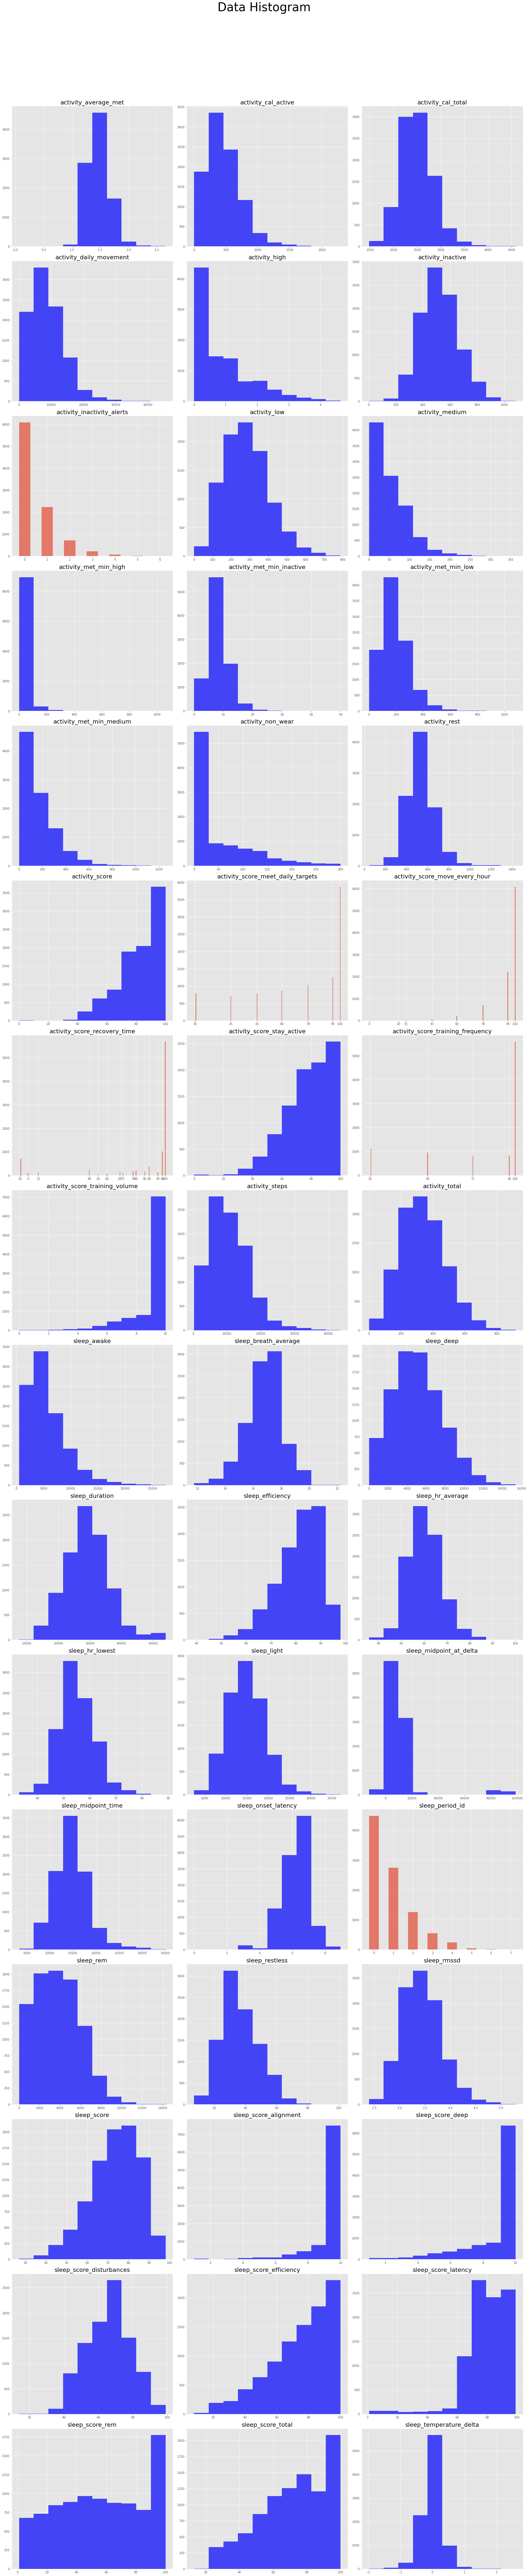

In [49]:
#data_activity = input_data_X.drop(['activity_met_1min', 'activity_class_5min'], axis=1)

plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,125))
plt.suptitle("Data Histogram", fontsize=40)

cols = input_data_X.columns
for i in range(len(cols)):
    plt.subplot(16,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(input_data_X[cols[i]].unique()) > 20:
        plt.hist(input_data_X[cols[i]], color='b', alpha=0.7)
    else:
        temp = input_data_X[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

In [48]:
input_data_X['sleep_score_deep'] = np.sqrt(input_data_X['sleep_score_deep'])
input_data_X['sleep_score_alignment'] = np.sqrt(input_data_X['sleep_score_alignment'])
input_data_X['sleep_rmssd'] = np.log1p(input_data_X['sleep_rmssd'])
input_data_X['sleep_onset_latency'] = np.log1p(input_data_X['sleep_onset_latency'])
##input_data_X['sleep_midpoint_at_delta'] = np.log1p(input_data_X['sleep_midpoint_at_delta'])
input_data_X['activity_score_training_volume'] = np.sqrt(input_data_X['activity_score_training_volume'])


input_data_X['activity_high'] = np.log1p(input_data_X['activity_high'])



## RobustScaler

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [51]:
input_data_X

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
0,1.719,730,2944,14346,0.000,417,0,545,47,0,...,3.045,62,10.000,6.403,50,27,97,66,62,-0.120
1,1.406,342,2449,6352,0.000,473,0,392,8,0,...,2.996,54,10.000,7.000,43,46,91,35,44,-0.320
2,1.469,401,2544,7297,0.000,586,0,362,24,0,...,3.296,61,10.000,7.483,47,34,89,41,62,0.070
3,0.344,27,1850,491,0.000,176,0,34,1,0,...,3.434,55,10.000,5.916,40,44,86,29,56,-0.410
4,1.469,333,2518,5861,0.000,646,0,377,6,0,...,3.178,56,10.000,8.000,55,39,14,54,59,-0.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.344,227,2316,3863,1.386,735,2,155,17,21,...,3.401,76,10.000,7.280,46,74,97,84,82,-0.160
9323,1.344,249,2351,4411,0.693,780,4,167,22,7,...,2.944,77,10.000,5.831,57,76,81,95,86,-0.090
9324,1.531,570,2682,11057,0.693,518,1,332,61,7,...,2.773,65,10.000,1.000,56,69,86,89,64,0.410
9325,1.344,295,2331,5135,1.609,578,0,173,30,28,...,2.890,81,10.000,3.000,59,86,89,98,97,0.270


In [52]:
Rscaler = RobustScaler()
result = Rscaler.fit_transform(input_data_X)
pd.options.display.float_format = '{:.3f}'.format
input_data_X_scaled = pd.DataFrame(result, columns=input_data_X.columns)

In [53]:
input_data_X_scaled

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
0,1.286,0.905,1.086,0.937,-0.500,-0.527,0.000,1.659,0.085,-0.318,...,-0.762,-0.812,0.000,-2.215,-0.941,-1.857,0.762,0.189,-0.387,-0.343
1,-0.143,-0.213,-0.036,-0.215,-0.500,-0.223,0.000,0.726,-0.576,-0.318,...,-0.858,-1.312,0.000,-1.825,-1.353,-1.179,0.476,-0.396,-0.968,-0.914
2,0.143,-0.043,0.179,-0.079,-0.500,0.391,0.000,0.543,-0.305,-0.318,...,-0.270,-0.875,0.000,-1.510,-1.118,-1.607,0.381,-0.283,-0.387,0.200
3,-5.000,-1.121,-1.395,-1.060,-0.500,-1.837,0.000,-1.457,-0.695,-0.318,...,0.000,-1.250,0.000,-2.532,-1.529,-1.250,0.238,-0.509,-0.581,-1.171
4,0.143,-0.239,0.120,-0.286,-0.500,0.717,0.000,0.634,-0.610,-0.318,...,-0.501,-1.188,0.000,-1.173,-0.647,-1.429,-3.190,-0.038,-0.484,-0.771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.429,-0.545,-0.338,-0.574,0.500,1.201,2.000,-0.720,-0.424,0.636,...,-0.064,0.062,0.000,-1.643,-1.176,-0.179,0.762,0.528,0.258,-0.457
9323,-0.429,-0.481,-0.259,-0.495,0.000,1.446,4.000,-0.646,-0.339,0.000,...,-0.958,0.125,0.000,-2.588,-0.529,-0.107,0.000,0.736,0.387,-0.257
9324,0.429,0.444,0.492,0.463,0.000,0.022,1.000,0.360,0.322,0.000,...,-1.295,-0.625,0.000,-5.739,-0.588,-0.357,0.238,0.623,-0.323,1.171
9325,-0.429,-0.349,-0.304,-0.390,0.661,0.348,0.000,-0.610,-0.203,0.955,...,-1.064,0.375,0.000,-4.435,-0.412,0.250,0.381,0.792,0.742,0.771


<AxesSubplot:>

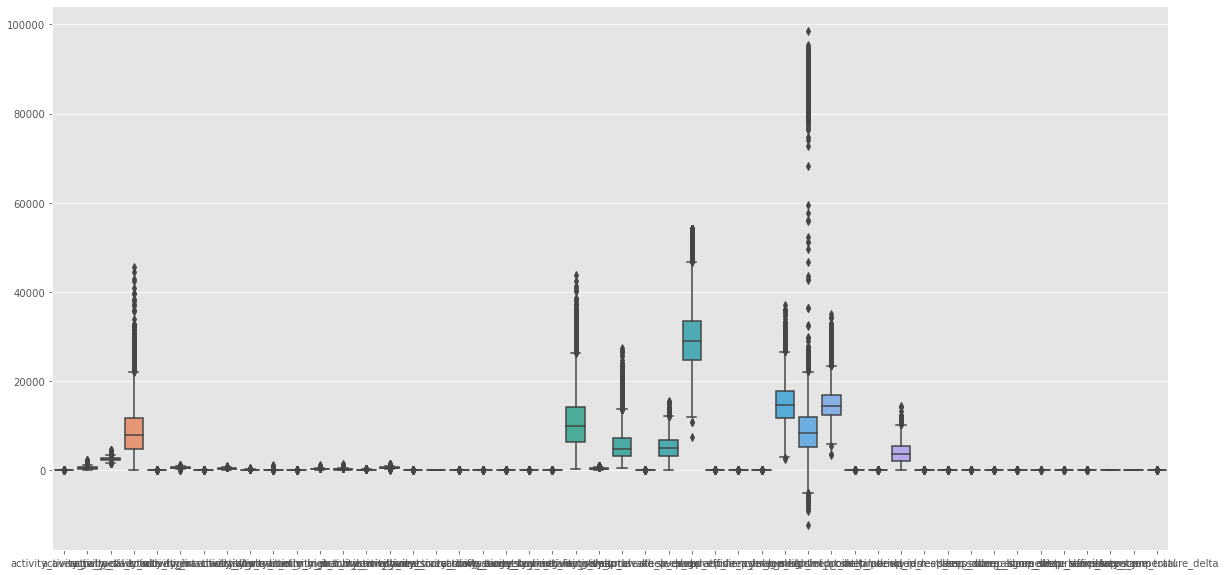

In [54]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=input_data_X)

<AxesSubplot:>

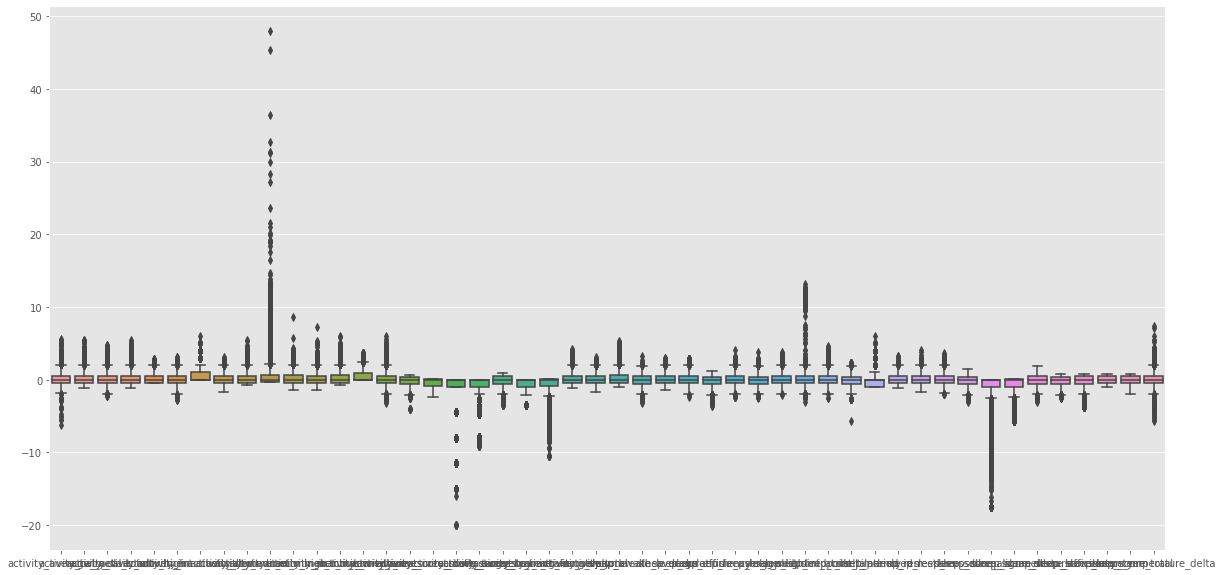

In [55]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=input_data_X_scaled)

In [56]:
input_data_X_scaled.describe()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
count,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,...,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000,9327.000
mean,0.114,0.126,0.068,0.120,0.080,0.043,0.500,0.054,0.164,0.628,...,0.014,-0.105,-1.098,-0.616,-0.022,-0.142,-0.064,0.002,-0.066,-0.032
std,0.860,0.769,0.789,0.757,0.690,0.752,0.819,0.730,0.747,2.145,...,0.764,0.730,2.398,1.142,0.750,0.702,0.710,0.562,0.658,0.901
min,-6.286,-1.199,-2.238,-1.131,-0.500,-2.777,0.000,-1.665,-0.712,-0.318,...,-2.028,-3.000,-17.538,-5.739,-3.059,-2.536,-3.810,-1.038,-1.968,-5.657
25%,-0.429,-0.447,-0.451,-0.449,-0.500,-0.484,0.000,-0.494,-0.424,-0.318,...,-0.501,-0.562,-1.000,-0.934,-0.529,-0.607,-0.524,-0.472,-0.516,-0.514
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.571,0.553,0.549,0.551,0.500,0.516,1.000,0.506,0.576,0.682,...,0.499,0.438,0.000,0.066,0.471,0.393,0.476,0.528,0.484,0.486
max,5.571,5.406,4.807,5.427,2.843,3.087,6.000,3.140,5.424,47.955,...,3.630,1.438,0.000,0.132,1.941,0.750,0.857,0.830,0.839,7.400


In [57]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X_scaled, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 6. Modeling - ML

- Linear model
    - Logistic Linear Regression 
- Tree model 
    - RandomForest 
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [58]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 

model_rf = RandomForestClassifier()

model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )
model_lgbm = LGBMClassifier()

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6562,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.567,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5496,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5322,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.55652


In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4796,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6193,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5181,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5543,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5228,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5388200000000001


In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4762,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6294,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5402,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5483,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5322,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.54526


In [62]:
pred_rf = model_rf.predict(test_X)

pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

## KNN

전처리 및 정규화를 추가 할수록 좋아질 가능성 높음

In [67]:
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(tr_val_X, tr_val_y)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(tr_val_X, tr_val_y)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(test_X, test_y) 

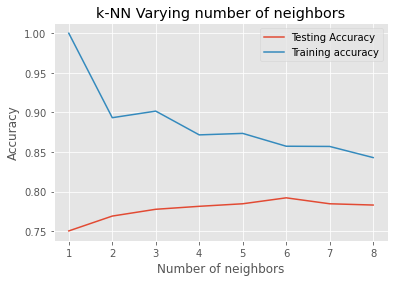

In [68]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [69]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(tr_val_X, tr_val_y)

KNeighborsClassifier(n_neighbors=6)

In [71]:
knn.score(test_X, test_y)

0.7920685959271169

# 7. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [63]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [64]:
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1194
           1       0.90      0.81      0.85       129
           2       0.92      0.69      0.79       543

    accuracy                           0.87      1866
   macro avg       0.89      0.82      0.85      1866
weighted avg       0.88      0.87      0.87      1866



In [65]:
print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.87      0.85      0.86       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



In [66]:
print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.88      0.86      0.87       129
           2       0.86      0.72      0.78       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866

